Define a Lightweight CNN Model

In [1]:
import torch
import torch.nn as nn

class TinyCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(TinyCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

    # Method to extract features before final layer
    def get_features(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
pip install tqdm

In [8]:
pip install tqdm pillow

In [9]:
import os
import random
import shutil
from tqdm import tqdm
from PIL import Image

# Paths
input_folder = "/content/drive/MyDrive/pomegranade/Balanced_Images_600"   # Folder with unbalanced class folders
balanced_folder = "/content/drive/MyDrive/pomegranade"
output_split_folder = "/content/drive/MyDrive/pomegranade"
target_count = 400
split_ratio = [0.7, 0.1, 0.2]  # train, val, test

# -----------------------------
# Step 1: Balance and Rename
# -----------------------------

os.makedirs(balanced_folder, exist_ok=True)

for class_name in tqdm(os.listdir(input_folder), desc="Balancing Classes"):
    class_path = os.path.join(input_folder, class_name)
    if not os.path.isdir(class_path):
        continue

    output_class_path = os.path.join(balanced_folder, class_name)
    os.makedirs(output_class_path, exist_ok=True)

    files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    random.shuffle(files)

    current_count = len(files)

    # Oversample or undersample
    balanced_files = []
    if current_count >= target_count:
        balanced_files = files[:target_count]
    else:
        balanced_files = files.copy()
        while len(balanced_files) < target_count:
            balanced_files.append(random.choice(files))

    # Rename and save
    for idx, file in enumerate(balanced_files[:target_count]):
        src = os.path.join(class_path, file)
        dst = os.path.join(output_class_path, f"{class_name}_{idx+1:04d}.jpg")
        try:
            img = Image.open(src)
            img = img.convert("RGB")  # Ensure RGB
            img.save(dst)
        except Exception as e:
            print(f"Error processing {src}: {e}")
            continue

# -----------------------------
# Step 2: Split Into Train / Val / Test
# -----------------------------

splits = ['train', 'val', 'test']
for split in splits:
    for class_name in os.listdir(balanced_folder):
        os.makedirs(os.path.join(output_split_folder, split, class_name), exist_ok=True)

for class_name in tqdm(os.listdir(balanced_folder), desc="Splitting Data"):
    class_path = os.path.join(balanced_folder, class_name)
    if not os.path.isdir(class_path):
        continue

    files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    random.shuffle(files)

    train_idx = int(len(files) * split_ratio[0])
    val_idx = train_idx + int(len(files) * split_ratio[1])

    train_files = files[:train_idx]
    val_files = files[train_idx:val_idx]
    test_files = files[val_idx:]

    # Copy files
    for f in train_files:
        shutil.copy(os.path.join(class_path, f), os.path.join(output_split_folder, 'train', class_name, f))

    for f in val_files:
        shutil.copy(os.path.join(class_path, f), os.path.join(output_split_folder, 'val', class_name, f))

    for f in test_files:
        shutil.copy(os.path.join(class_path, f), os.path.join(output_split_folder, 'test', class_name, f))

print("✅ Done!")
print(f"- Balanced dataset saved at: {balanced_folder}")
print(f"- Train/Val/Test split saved at: {output_split_folder}")

Splitting Data: 100%|██████████| 9/9 [00:58<00:00,  6.48s/it]

✅ Done!
- Balanced dataset saved at: /content/drive/MyDrive/pomegranade
- Train/Val/Test split saved at: /content/drive/MyDrive/pomegranade


In [10]:
pip install torch torchvision scikit-learn tqdm torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


**Lightweight CNN Model**

In [11]:
import torch
import torch.nn as nn

class TinyCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(TinyCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

    # Extract feature vector before final layer
    def get_features(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)

**Load Data & Train the CNN**

In [13]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
import torch

# Define transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Load datasets
train_dataset = datasets.ImageFolder('/content/drive/MyDrive/pomegranade/train', transform=transform)
val_dataset = datasets.ImageFolder('/content/drive/MyDrive/pomegranade/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TinyCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early Stopping Parameters
patience = 5
min_val_loss = float('inf')
no_improvement = 0
best_model_path = 'best_cnn_model.pth'

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Metrics
    train_acc = 100 * train_correct / train_total
    val_acc = 100 * val_correct / val_total
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_acc:.2f}%")

    # Early stopping logic
    if avg_val_loss < min_val_loss:
        min_val_loss = avg_val_loss
        no_improvement = 0
        torch.save(model.state_dict(), best_model_path)  # Save best model
    else:
        no_improvement += 1

    if no_improvement >= patience:
        print("🛑 Early stopping triggered.")
        break

# Load best model
model.load_state_dict(torch.load(best_model_path))
print("✅ Best model loaded.")

Epoch 1 | Train Loss: 1.5810 | Train Acc: 25.21% | Val Loss: 1.4555 | Val Acc: 35.00%
Epoch 2 | Train Loss: 1.3285 | Train Acc: 39.64% | Val Loss: 1.1231 | Val Acc: 40.50%
Epoch 3 | Train Loss: 1.1978 | Train Acc: 44.71% | Val Loss: 1.0742 | Val Acc: 46.50%
Epoch 4 | Train Loss: 1.1707 | Train Acc: 46.29% | Val Loss: 1.0472 | Val Acc: 59.00%
Epoch 5 | Train Loss: 1.1323 | Train Acc: 49.57% | Val Loss: 1.0032 | Val Acc: 60.50%
Epoch 6 | Train Loss: 1.0684 | Train Acc: 55.86% | Val Loss: 0.9296 | Val Acc: 59.50%
Epoch 7 | Train Loss: 1.0333 | Train Acc: 57.57% | Val Loss: 0.8505 | Val Acc: 73.00%
Epoch 8 | Train Loss: 0.9622 | Train Acc: 60.36% | Val Loss: 0.8134 | Val Acc: 70.00%
Epoch 9 | Train Loss: 0.8990 | Train Acc: 64.07% | Val Loss: 0.7568 | Val Acc: 72.50%
Epoch 10 | Train Loss: 0.8843 | Train Acc: 65.07% | Val Loss: 0.7937 | Val Acc: 70.00%
Epoch 11 | Train Loss: 0.8481 | Train Acc: 66.71% | Val Loss: 0.7079 | Val Acc: 74.50%
Epoch 12 | Train Loss: 0.8371 | Train Acc: 67.57% | 

**Extract Features from Train / Val / Test**

In [17]:
import numpy as np
def extract_features(loader, model):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, batch_labels in loader:
            feats = model.get_features(images)
            features.append(feats.numpy())
            labels.append(batch_labels.numpy())
    return np.concatenate(features), np.concatenate(labels)

# Run on all splits
train_features, train_labels = extract_features(train_loader, model)
val_features, val_labels = extract_features(val_loader, model)

print("Feature extraction complete!")

Feature extraction complete!


**Build Graph Using Cosine Similarity**

In [24]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split

# Assume:
# - x = torch tensor of shape [num_samples, feature_dim]
# - y = torch tensor of shape [num_samples] (class labels)

num_samples = len(y)  # Total number of images/nodes

# Split indices
indices = np.arange(num_samples)
train_idx, test_idx = train_test_split(indices, train_size=0.7, stratify=y.numpy(), random_state=42)
train_idx, val_idx = train_test_split(train_idx, train_size=0.86, stratify=y[train_idx].numpy(), random_state=42)

# Create masks
def index_to_mask(index, size):
    mask = torch.zeros(size, dtype=torch.bool)
    mask[index] = True
    return mask

train_mask = index_to_mask(train_idx, num_samples)
val_mask = index_to_mask(val_idx, num_samples)
test_mask = index_to_mask(test_idx, num_samples)

# Add masks to data object
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

In [19]:
pip install torch-geometric matplotlib scikit-learn seaborn

**Train a GNN (GCN) on the Graph**

Epoch 1 | Train Loss: 3.3161 | Train Acc: 19.98% | Val Loss: 3.2476 | Val Acc: 20.29%
Epoch 2 | Train Loss: 2.4807 | Train Acc: 19.98% | Val Loss: 2.4485 | Val Acc: 20.29%
Epoch 3 | Train Loss: 1.8498 | Train Acc: 39.24% | Val Loss: 1.8246 | Val Acc: 39.86%
Epoch 4 | Train Loss: 1.9554 | Train Acc: 19.98% | Val Loss: 1.9114 | Val Acc: 20.29%
Epoch 5 | Train Loss: 1.8131 | Train Acc: 19.98% | Val Loss: 1.7795 | Val Acc: 20.29%
Epoch 6 | Train Loss: 1.6384 | Train Acc: 19.98% | Val Loss: 1.6257 | Val Acc: 20.29%
Epoch 7 | Train Loss: 1.7300 | Train Acc: 20.10% | Val Loss: 1.7246 | Val Acc: 19.57%
Epoch 8 | Train Loss: 1.8232 | Train Acc: 20.10% | Val Loss: 1.8187 | Val Acc: 19.57%
Epoch 9 | Train Loss: 1.7491 | Train Acc: 20.10% | Val Loss: 1.7461 | Val Acc: 19.57%
Epoch 10 | Train Loss: 1.5967 | Train Acc: 21.76% | Val Loss: 1.5924 | Val Acc: 15.94%
Epoch 11 | Train Loss: 1.4792 | Train Acc: 38.88% | Val Loss: 1.4668 | Val Acc: 38.41%
Epoch 12 | Train Loss: 1.4495 | Train Acc: 46.37% | 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


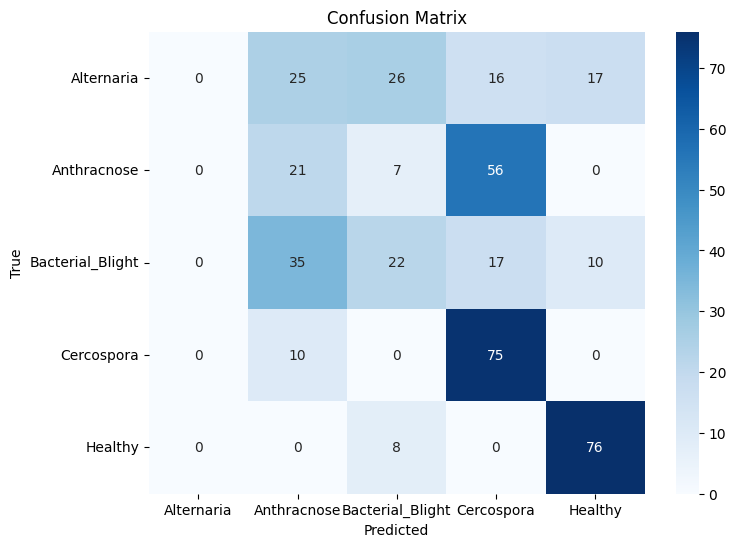

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [25]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# -----------------------------
# GCN Model Definition
# -----------------------------
class GCN(torch.nn.Module):
    def __init__(self, num_features=64, hidden_dim=32, num_classes=5):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# -----------------------------
# Initialize Model & Optimizer
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gnn_model = GCN().to(device)
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
criterion = torch.nn.NLLLoss()

# Move data to device
data = data.to(device)

# -----------------------------
# Early Stopping Setup
# -----------------------------
patience = 10
min_val_loss = float('inf')
no_improvement = 0
best_model_path = 'best_gcn_model.pth'

# Track metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# -----------------------------
# Train Loop with Val Metrics
# -----------------------------
num_epochs = 50
for epoch in range(num_epochs):
    gnn_model.train()
    optimizer.zero_grad()
    out = gnn_model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Use train mask

    # Backward pass
    loss.backward()
    optimizer.step()

    # Evaluate
    gnn_model.eval()
    pred = gnn_model(data)

    # Compute train metrics
    train_pred = pred.argmax(dim=1)[data.train_mask]
    train_true = data.y[data.train_mask]
    train_loss = criterion(pred[data.train_mask], train_true).item()
    train_acc = (train_pred == train_true).sum().item() / data.train_mask.sum().item()

    # Compute val metrics
    val_pred = pred.argmax(dim=1)[data.val_mask]
    val_true = data.y[data.val_mask]
    val_loss = criterion(pred[data.val_mask], val_true).item()
    val_acc = (val_pred == val_true).sum().item() / data.val_mask.sum().item()

    # Save metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Train Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc*100:.2f}%")

    # Early stopping
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        no_improvement = 0
        torch.save(gnn_model.state_dict(), best_model_path)
    else:
        no_improvement += 1

    if no_improvement >= patience:
        print("🛑 Early stopping triggered.")
        break

# Load best model
gnn_model.load_state_dict(torch.load(best_model_path))
gnn_model.eval()
final_pred = gnn_model(data)

# Get test predictions
test_pred = final_pred.argmax(dim=1)[data.test_mask].cpu().numpy()
test_true = data.y[data.test_mask].cpu().numpy()

# -----------------------------
# Final Evaluation Metrics
# -----------------------------
print("\n📊 Test Classification Report:")
print(classification_report(test_true, test_pred, digits=4))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(test_true, test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve (One-vs-Rest for multi-class)
y_true_bin = label_binarize(test_true, classes=[0, 1, 2, 3, 4])
y_score = torch.exp(final_pred[data.test_mask]).cpu().numpy()

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(train_dataset.classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.show()

# -----------------------------
# Loss and Accuracy Curves
# -----------------------------
epochs_run = len(train_losses)
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(range(epochs_run), train_losses, label='Train Loss')
plt.plot(range(epochs_run), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(epochs_run), train_accuracies, label='Train Accuracy')
plt.plot(range(epochs_run), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

using mobilenetv2

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np

In [30]:
# Define data generators
def create_generators(base_dir, target_size=(128, 128), batch_size=32):
    datagen = ImageDataGenerator(rescale=1./255)

    train_gen = datagen.flow_from_directory(
        os.path.join(base_dir, "train"),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )
    val_gen = datagen.flow_from_directory(
        os.path.join(base_dir, "val"),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    test_gen = datagen.flow_from_directory(
        os.path.join(base_dir, "test"),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    return train_gen, val_gen, test_gen


# Evaluate function
def evaluate_model(model, test_generator):
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    test_loss, test_acc = model.evaluate(test_generator, verbose=0)
    print(f"Test Accuracy: {test_acc*100:.2f}%")

In [32]:
base_dir = "/content/drive/MyDrive/pomegranade"
train_gen, val_gen, test_gen = create_generators(base_dir)

# Load MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Train
model.fit(train_gen, validation_data=val_gen, epochs=20)

# Evaluate
evaluate_model(model, test_gen)

Found 1400 images belonging to 5 classes.
Found 200 images belonging to 5 classes.
Found 400 images belonging to 5 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - accuracy: 0.2979 - loss: 1.9898 - val_accuracy: 0.8500 - val_loss: 0.5945
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - accuracy: 0.7511 - loss: 0.6913 - val_accuracy: 0.9200 - val_loss: 0.3473
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.8571 - loss: 0.4393 - val_accuracy: 0.9350 - val_loss: 0.2690
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.8896 - loss: 0.3669 - val_accuracy: 0.9250 - val_loss: 0.2369
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.9112 - loss: 0.2761 - val_accuracy: 0.9450 - val_loss: 0.2064
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 126s 3s/step - accuracy: 0.9315 - loss: 0.2375 - val_accuracy: 0.9450 - val_loss: 0.1948
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.9301 - loss: 0.2015 - val_accuracy: 0.9500 - val_loss: 0.1869
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.9475 - loss: 0.1814 - val_accuracy: 0.9600 - v

# Extract Features Using MobileNetV2

In [34]:
# Create feature extractor (remove final layers)
feature_extractor = Model(inputs=model.input, outputs=model.get_layer(index=-3).output)

def extract_features(generator, extractor):
    features = []
    labels = []
    generator.reset()

    for i in range(len(generator)):
        x, y = generator[i]  # <-- Fixed line
        feat = extractor.predict(x, verbose=0)
        features.append(feat)
        labels.append(y)

    return np.vstack(features), np.vstack(labels)

# Extract features from all sets
train_features, train_labels = extract_features(train_gen, feature_extractor)
val_features, val_labels = extract_features(val_gen, feature_extractor)
test_features, test_labels = extract_features(test_gen, feature_extractor)

print("✅ Features extracted:", train_features.shape, val_features.shape, test_features.shape)

✅ Features extracted: (1400, 256) (200, 256) (400, 256)


In [37]:
# Combine all features and labels
features = np.vstack([train_features, val_features, test_features])
labels = np.argmax(np.vstack([
    train_labels, val_labels, test_labels
]), axis=1)

print("Combined features:", features.shape)
print("Combined labels:", labels.shape)

Combined features: (2000, 256)
Combined labels: (2000,)


In [38]:
# Compute cosine similarity
sim_matrix = cosine_similarity(features)

# Threshold to build edges
threshold = 0.90
edges = np.where(sim_matrix > threshold)

# Convert to PyTorch tensors
edge_index = torch.tensor(np.array(edges), dtype=torch.long)
x = torch.tensor(features, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.long)

# Split indices
num_total = len(labels)
indices = np.arange(num_total)

train_idx, test_idx = train_test_split(indices, train_size=0.7, stratify=labels, random_state=42)
train_idx, val_idx = train_test_split(train_idx, train_size=0.85, stratify=labels[train_idx], random_state=42)

# Create masks
def index_to_mask(index, size):
    mask = torch.zeros(size, dtype=torch.bool)
    mask[index] = True
    return mask

train_mask = index_to_mask(train_idx, num_total)
val_mask = index_to_mask(val_idx, num_total)
test_mask = index_to_mask(test_idx, num_total)

# Final data object
data = Data(x=x, edge_index=edge_index, y=y)
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

print("✅ Graph built:", data)

✅ Graph built: Data(x=[2000, 256], edge_index=[2, 8424], y=[2000], train_mask=[2000], val_mask=[2000], test_mask=[2000])


In [44]:
class GCN(torch.nn.Module):
    def __init__(self, num_features=256, hidden_dim=128, num_classes=5):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gnn_model = GCN().to(device)
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
criterion = torch.nn.NLLLoss()

data = data.to(device)

# Early stopping
patience = 10
min_val_loss = float('inf')
no_improvement = 0
best_model_path = 'best_gcn_model.pth'

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(100):
    gnn_model.train()
    optimizer.zero_grad()
    out = gnn_model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])

    loss.backward()
    optimizer.step()

    # Evaluation
    gnn_model.eval()
    pred = gnn_model(data)

    # Loss
    train_loss = criterion(pred[data.train_mask], data.y[data.train_mask]).item()
    val_loss = criterion(pred[data.val_mask], data.y[data.val_mask]).item()

    # Accuracy
    train_acc = (pred[data.train_mask].argmax(dim=1) == data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()
    val_acc = (pred[data.val_mask].argmax(dim=1) == data.y[data.val_mask]).sum().item() / data.val_mask.sum().item()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Train Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc*100:.2f}%")

    # Early stopping
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        no_improvement = 0
        torch.save(gnn_model.state_dict(), best_model_path)
    else:
        no_improvement += 1

    if no_improvement >= patience:
        print("🛑 Early stopping triggered.")
        break

# Load best model
gnn_model.load_state_dict(torch.load(best_model_path))
gnn_model.eval()
final_pred = gnn_model(data)

Epoch 1 | Train Loss: 0.6377 | Train Acc: 78.74% | Val Loss: 0.6744 | Val Acc: 77.62%
Epoch 2 | Train Loss: 0.1262 | Train Acc: 96.97% | Val Loss: 0.1293 | Val Acc: 96.67%
Epoch 3 | Train Loss: 0.1115 | Train Acc: 96.72% | Val Loss: 0.1244 | Val Acc: 96.19%
Epoch 4 | Train Loss: 0.1366 | Train Acc: 95.71% | Val Loss: 0.1573 | Val Acc: 95.71%
Epoch 5 | Train Loss: 0.1004 | Train Acc: 97.14% | Val Loss: 0.1236 | Val Acc: 95.71%
Epoch 6 | Train Loss: 0.0687 | Train Acc: 98.57% | Val Loss: 0.0791 | Val Acc: 96.19%
Epoch 7 | Train Loss: 0.0577 | Train Acc: 98.82% | Val Loss: 0.0499 | Val Acc: 97.14%
Epoch 8 | Train Loss: 0.0594 | Train Acc: 98.57% | Val Loss: 0.0451 | Val Acc: 98.57%
Epoch 9 | Train Loss: 0.0635 | Train Acc: 98.49% | Val Loss: 0.0524 | Val Acc: 98.10%
Epoch 10 | Train Loss: 0.0624 | Train Acc: 98.57% | Val Loss: 0.0605 | Val Acc: 96.67%
Epoch 11 | Train Loss: 0.0566 | Train Acc: 98.57% | Val Loss: 0.0653 | Val Acc: 96.67%
Epoch 12 | Train Loss: 0.0493 | Train Acc: 98.66% | 


📊 Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       120
           1       0.97      0.99      0.98       120
           2       0.97      0.97      0.97       120
           3       0.97      0.96      0.96       120
           4       0.99      0.99      0.99       120

    accuracy                           0.97       600
   macro avg       0.98      0.97      0.97       600
weighted avg       0.98      0.97      0.97       600



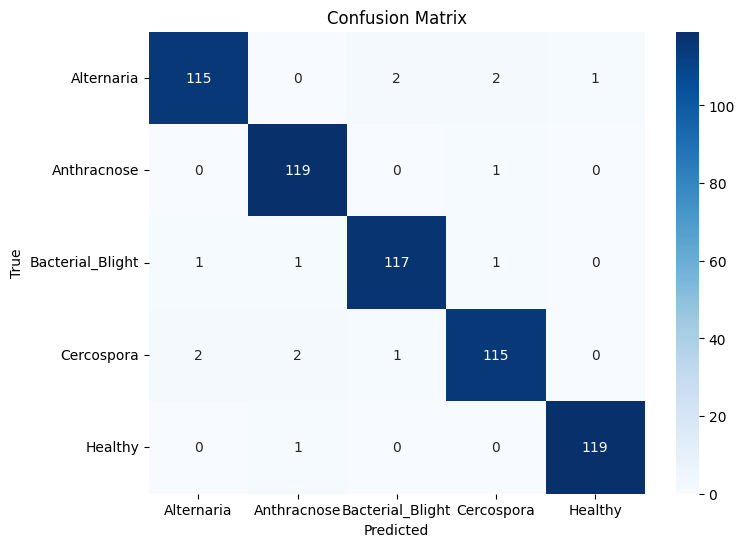

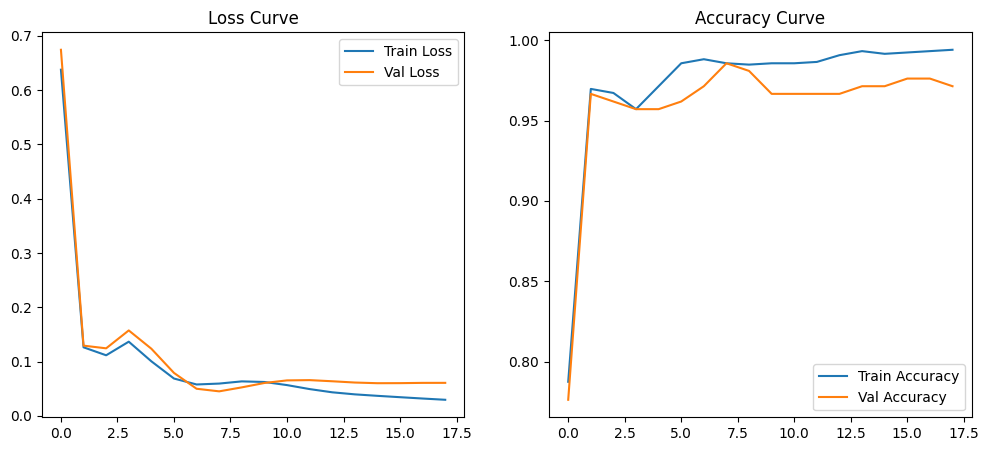

In [45]:
# Test predictions
test_pred = final_pred.argmax(dim=1)[data.test_mask].cpu().numpy()
test_true = data.y[data.test_mask].cpu().numpy()

# Classification Report
print("\n📊 Test Classification Report:")
print(classification_report(test_true, test_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(test_true, test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_gen.class_indices.keys(),
            yticklabels=train_gen.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Accuracy & Loss Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.title("Accuracy Curve")
plt.show()


📊 Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       120
           1       0.97      0.99      0.98       120
           2       0.97      0.97      0.97       120
           3       0.97      0.96      0.96       120
           4       0.99      0.99      0.99       120

    accuracy                           0.97       600
   macro avg       0.98      0.97      0.97       600
weighted avg       0.98      0.97      0.97       600



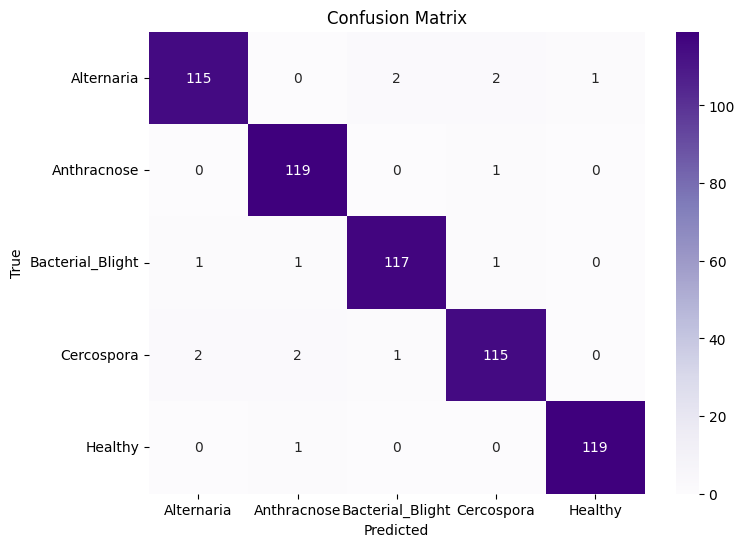

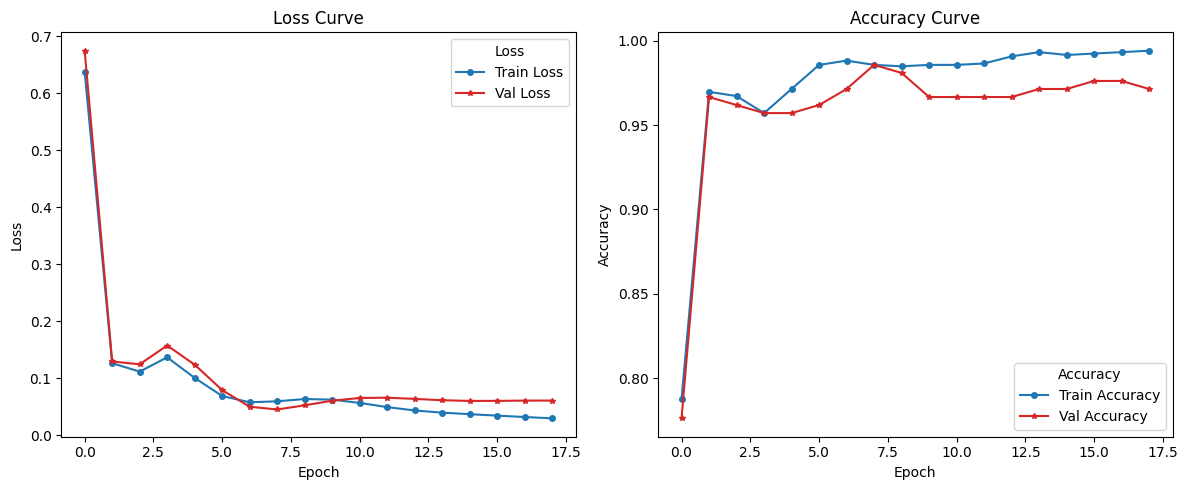

In [72]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Ensure final_pred is updated with the latest predictions
test_pred = final_pred.argmax(dim=1)[data.test_mask].cpu().numpy()
test_true = data.y[data.test_mask].cpu().numpy()

# Classification Report
print("\n📊 Test Classification Report:")
print(classification_report(test_true, test_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(test_true, test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=train_gen.class_indices.keys(),
            yticklabels=train_gen.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

# Save Confusion Matrix
plt.savefig('confusion_matrix.png', dpi=600, bbox_inches='tight')
plt.show()

# Accuracy & Loss Curves
plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
train_loss_line, = plt.plot(train_losses, label='Train Loss', color='#1f77b4', marker='o', markersize=4)
val_loss_line, = plt.plot(val_losses, label='Val Loss', color='#d62728', marker='*', markersize=4)
plt.legend(handles=[train_loss_line, val_loss_line], title="Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Accuracy Curve
plt.subplot(1, 2, 2)
train_acc_line, = plt.plot(train_accuracies, label='Train Accuracy', color='#1f77b4', marker='o', markersize=4)
val_acc_line, = plt.plot(val_accuracies, label='Val Accuracy', color='#d62728', marker='*', markersize=4)
plt.legend(handles=[train_acc_line, val_acc_line], title="Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()

# Save Accuracy/Loss Plot
plt.savefig('accuracy_loss_curves.png', dpi=600, bbox_inches='tight')
plt.show()

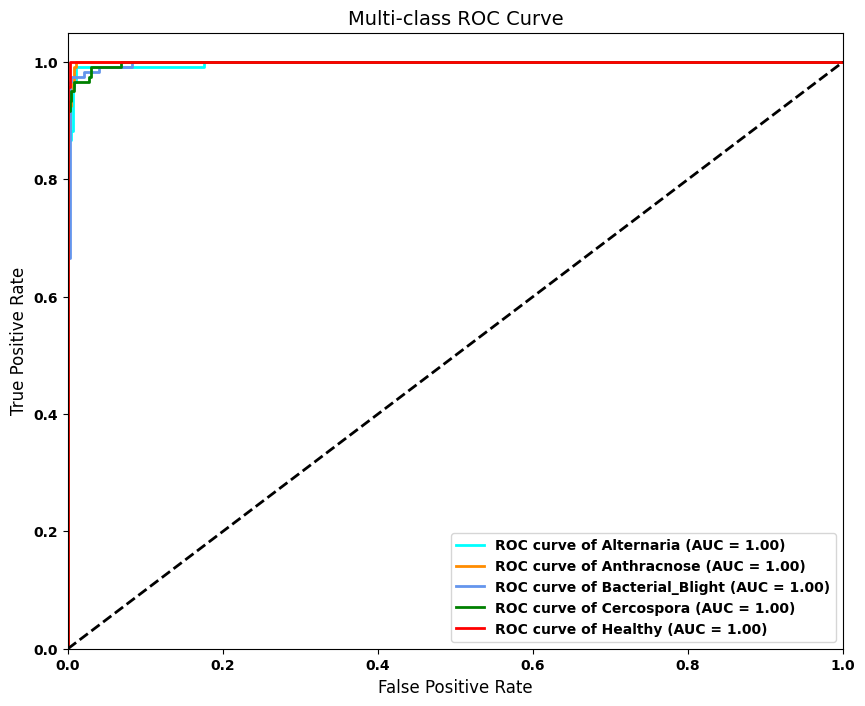

In [84]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the true labels for multi-class ROC
y_true_bin = label_binarize(test_true, classes=[0, 1, 2, 3, 4])
n_classes = y_true_bin.shape[1]

# Get predicted probabilities from the model (assuming log_softmax output)
probs = torch.exp(final_pred[data.test_mask].detach().cpu()).numpy()

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red']
class_names = list(train_gen.class_indices.keys())  # Make sure train_gen is defined

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {0} (AUC = {1:0.2f})'
                   ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-class ROC Curve', fontsize=14)
plt.legend(loc="lower right", fontsize=10)

# Save before showing the plot
plt.savefig('roc_curve.png', dpi=1200, bbox_inches='tight')  # High-resolution
plt.show()


In [48]:
print("Class-wise AUC:")
for i in range(n_classes):
    print(f"{class_names[i]}: {roc_auc[i]:.4f}")

Class-wise AUC:
Alternaria: 0.9977
Anthracnose: 0.9994
Bacterial_Blight: 0.9981
Cercospora: 0.9985
Healthy: 0.9999


In [49]:
# From earlier steps
test_pred = final_pred.argmax(dim=1)[data.test_mask].cpu().numpy()
test_true = data.y[data.test_mask].cpu().numpy()

In [52]:
misclassified_indices = np.where(test_pred != test_true)[0]

print("Misclassified Images:")
for i in misclassified_indices:
    print(f"Image {i}: True = {test_true[i]}, Pred = {test_pred[i]}")

Misclassified Images:
Image 2: True = 3, Pred = 0
Image 18: True = 3, Pred = 1
Image 128: True = 2, Pred = 0
Image 155: True = 3, Pred = 2
Image 158: True = 0, Pred = 2
Image 199: True = 1, Pred = 3
Image 246: True = 0, Pred = 3
Image 418: True = 2, Pred = 3
Image 425: True = 0, Pred = 2
Image 464: True = 3, Pred = 0
Image 465: True = 3, Pred = 1
Image 472: True = 4, Pred = 1
Image 487: True = 0, Pred = 3
Image 495: True = 0, Pred = 4
Image 527: True = 2, Pred = 1


In [56]:
def plot_predictions(indices, test_generator, test_true, test_pred, class_names):
    plt.figure(figsize=(15, 9))

    # Re-run generator and collect all images and labels
    test_generator.reset()
    all_images = []
    for i in range(len(test_generator)):
        x, _ = test_generator[i]
        all_images.append(x)
    all_images = np.vstack(all_images)

    # Make sure indices are within bounds
    valid_indices = [idx for idx in indices if idx < len(all_images)]

    for i, idx in enumerate(valid_indices[:15]):  # Show up to first 15 valid samples
        plt.subplot(3, 5, i + 1)
        img = all_images[idx]  # Get image directly from array
        plt.imshow(img.clip(0,1))  # Clip values for display safety
        plt.title(f"T: {class_names[test_true[idx]]}\nP: {class_names[test_pred[idx]]}", fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

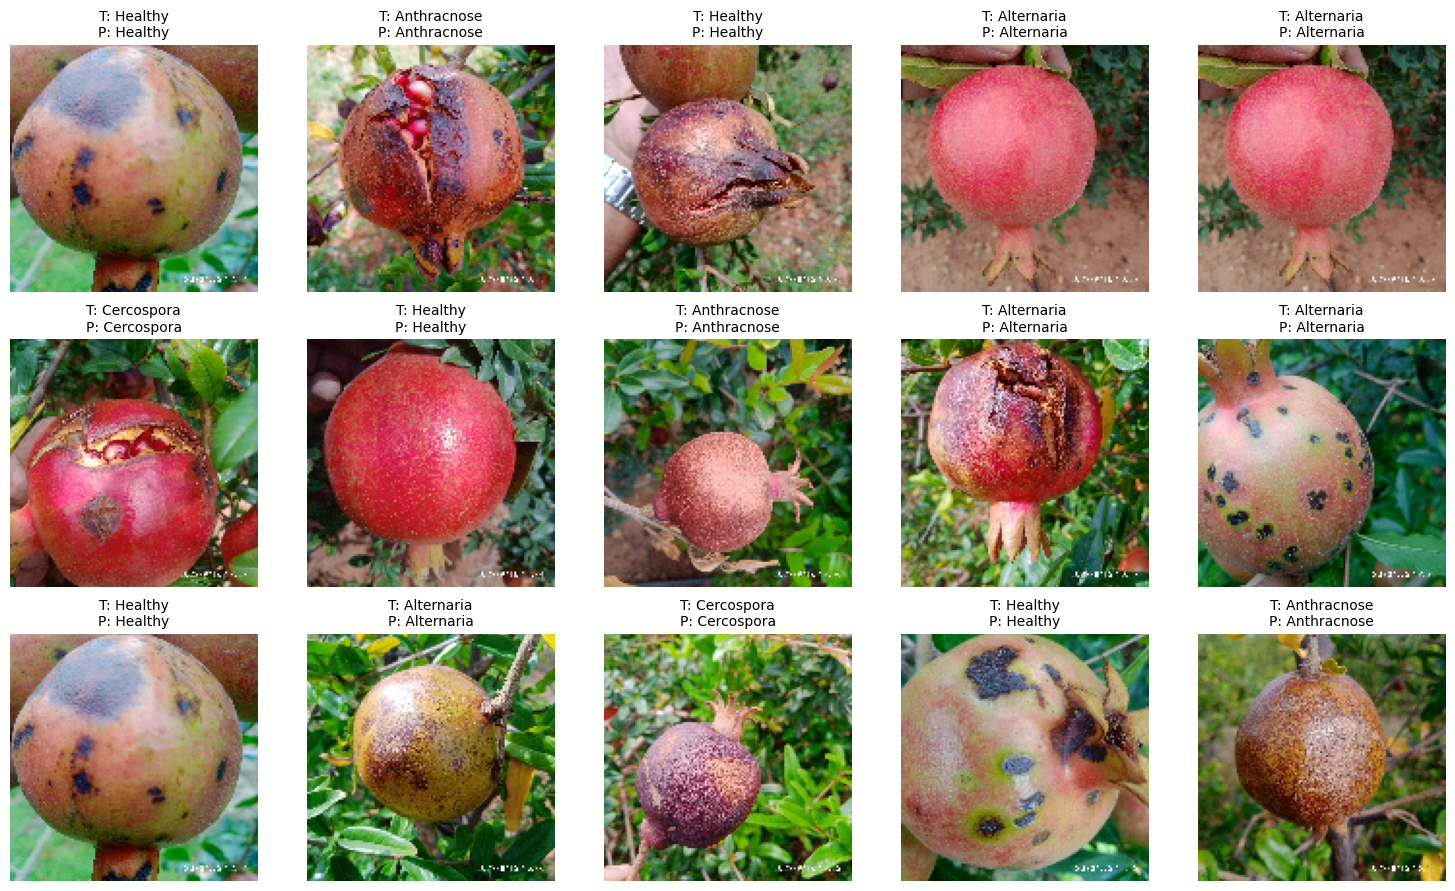

In [57]:
class_names = list(train_gen.class_indices.keys())

# Plot predictions — generate only valid indices
num_samples = len(test_true)
random_indices = np.random.randint(0, num_samples, 50)  # Safe range

plot_predictions(random_indices, test_gen, test_true, test_pred, class_names)

In [58]:
pip install networkx matplotlib

In [59]:
import networkx as nx
import matplotlib.pyplot as plt

# Convert edge_index to numpy
edges = edge_index.cpu().numpy()

# Build NetworkX graph
G = nx.Graph()

# Add edges
for i in range(edges.shape[1]):
    src = edges[0, i]
    dst = edges[1, i]
    G.add_edge(src, dst)

print("Graph built with", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

Graph built with 2000 nodes and 5212 edges


In [63]:
pip install plotly

In [67]:
import plotly.graph_objects as go
import networkx as nx

# Use the same subgraph from earlier
H = G.subgraph(range(30))  # 30 nodes for clarity
pos = nx.spring_layout(H, seed=42)  # Or use nx.fruchterman_reingold_layout(H)

# Create edges
edge_x = []
edge_y = []
for edge in H.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# Draw edges
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Draw nodes
node_x = []
node_y = []
node_text = []
node_color = []

for node in H.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(f"Node {node}<br>Class: {class_names[test_true[node]]}")
    node_color.append(test_true[node])  # Color by true class

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=[class_names[test_true[n]] for n in H.nodes()],
    textposition="bottom center",
    hovertext=node_text,
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='Rainbow',
        size=10,
        color=node_color,
        colorbar=dict(
            thickness=15,
            title='Disease Class',
            xanchor='left',
            titleside='right'
        )
    ))

# Build figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Interactive Disease Image Similarity Graph (Plotly)',
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, visible=False),
                    yaxis=dict(showgrid=False, zeroline=False, visible=False)))

fig.show()

In [65]:
pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.0 MB/s eta 0:00:00


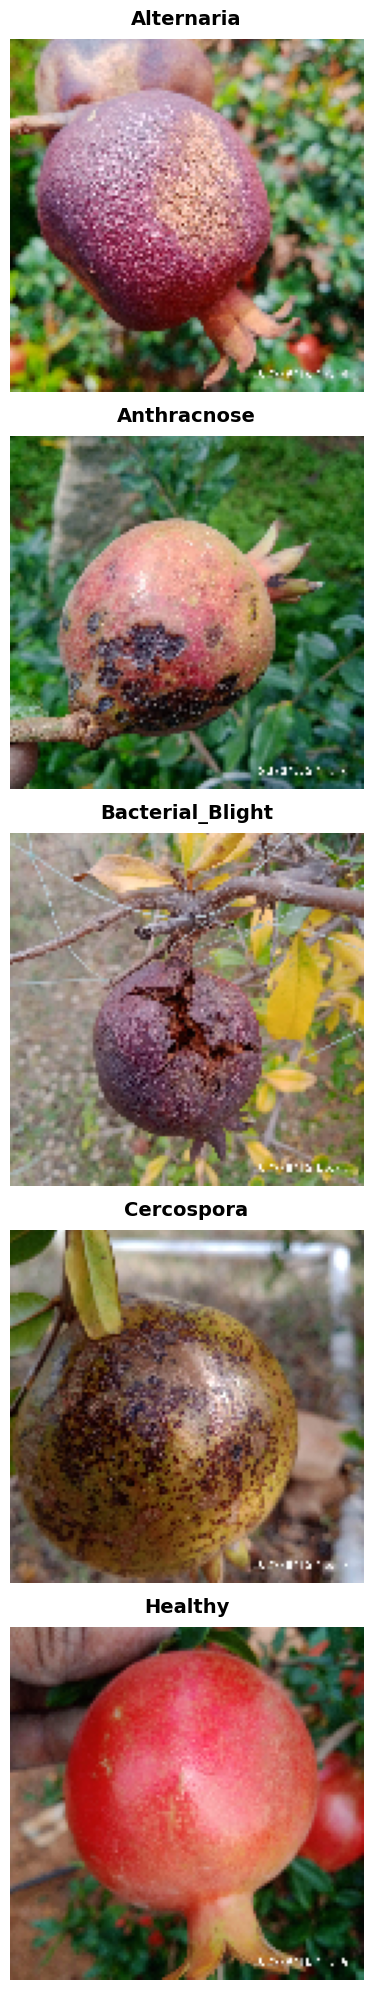

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# Get class names
class_names = list(train_gen.class_indices.keys())
num_classes = len(class_names)

# Prepare to find one image per class
found_images = {}  # {class_idx: image_array}

# Loop through all batches
for i in range(len(test_gen)):
    try:
        batch_images, batch_labels = test_gen[i]
        for j in range(batch_images.shape[0]):
            true_label = np.argmax(batch_labels[j]) if len(batch_labels.shape) > 1 else batch_labels[j]
            if true_label not in found_images:
                found_images[true_label] = batch_images[j]
            if len(found_images) == num_classes:
                break
        if len(found_images) == num_classes:
            break
    except Exception as e:
        print(f"Error loading batch {i}: {e}")
        continue

# Plotting - 5 rows, 1 column
fig, axes = plt.subplots(nrows=num_classes, ncols=1, figsize=(6, 20))

# Bold fonts
plt.rcParams['font.weight'] = 'bold'

for idx in range(num_classes):
    ax = axes[idx]
    ax.imshow(found_images[idx])
    ax.set_title(f"{class_names[idx]}", fontsize=14, fontweight='bold', pad=10)
    ax.axis('off')

plt.tight_layout()

# Save high-resolution version
plt.savefig("sample_images_per_class_vertical.png", dpi=600, bbox_inches='tight')
plt.show()

In [79]:
import torch

# Make sure this is your PyTorch GCN model
gnn_model = GCN()  # Re-initialize if needed

# Print model structure
print("🧾 GCN Model Architecture:\n", gnn_model)

# Count trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n🔢 Total Trainable Parameters: {count_parameters(gnn_model):,}")

🧾 GCN Model Architecture:
 GCN(
  (conv1): GCNConv(256, 128)
  (conv2): GCNConv(128, 5)
)

🔢 Total Trainable Parameters: 33,541


In [80]:
pip install torchviz

In [81]:
import torch
from torch_geometric.nn import GCNConv
from torchviz import make_dot

# Re-define a simple forward pass for visualization
class GCNVis(torch.nn.Module):
    def __init__(self, num_features=256, hidden_dim=128, num_classes=5):
        super(GCNVis, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        return x.log_softmax(dim=1)

# Dummy inputs for visualization
num_nodes = 10  # We'll simulate a small graph
num_features = 256

x = torch.randn(num_nodes, num_features)  # Node features
edge_index = torch.randint(0, num_nodes, (2, num_nodes * 2))  # Random edges

model = GCNVis()
out = model(x, edge_index)

# Create and render the diagram
vis = make_dot(out, params=dict(model.named_parameters()))
vis.format = "png"
vis.filename = "gcn_architecture"
vis.directory = "./"
vis.render()

print("✅ Saved GNN architecture diagram as 'gcn_architecture.png'")

✅ Saved GNN architecture diagram as 'gcn_architecture.png'
